In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D

In [26]:
## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                    # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Control parameters
alpha = 1000
tau = 10



## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)
controlgain = 1

## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Inital state of Lorenz system, reservoir states and forcing function
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))


### Training using the pre-defined forcing functions ###

## Collecting reservoir time-series data for delayed control
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r

    fx = 10 * np.cos(0.05 * dt * t)
    fy = 10 * np.sin(0.05 * dt * t)
    
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)


## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  ## For delayed control


### Training for feedback control

## Inital state of Lorenz system, reservoir states and forcing function
rfeed = 0.5 - 1.0 * np.random.rand(n)
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rfeed
    

    xp = sigma * (y - x)
    yp = x * (rho - z) - y 
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rfeed = np.tanh(A.dot(rfeed) + Win.dot(u) + 1)
    f[:, t] = np.array([x, y, z])

## Finding Wout matrix using ridge regression
Wout_feed = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  ## For feedback control


### Testing delayed control with altered rho ###

Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## The portion from here-on down should be repeated for different values of parameters

## Disturbance range is 0 - 20
## For each disturbance value, repeat the run 3 times and take average of 3


disturbance_range = np.linspace(0, 40, 81)   # change in rho
numberofeach = 3
trials = numberofeach * disturbance_range.shape[0]
avgdistcontrol = np.zeros(trials)
avgdistnocont = np.zeros(trials)
avgdistfeed = np.zeros(trials)
trial_counter = 0
r_init = r
point_indices = np.random.randint(0, 5000 - 1, size = 100)

for disturbance in disturbance_range:
    for attempt in np.arange(numberofeach):

        r = r_init
        rfeed = r_init 
        ux = np.zeros(ntest + 1)
        vx = np.zeros(ntest + 1)

        uy = np.zeros(ntest + 1)
        vy = np.zeros(ntest + 1)


        uz = np.zeros(ntest + 1)
        vz = np.zeros(ntest + 1)

        ## Storing x, y, z time series data when there is disturbance and delayed control is applied
        xcontrol = np.zeros(ntest)             
        ycontrol = np.zeros(ntest)
        zcontrol = np.zeros(ntest)

        ## Storing x, y, z time series data when there is disturbance and feedback control is applied
        xfeed = np.zeros(ntest)             
        yfeed = np.zeros(ntest)
        zfeed = np.zeros(ntest)

        ## Storing x, y, z time series data when there is disturbance and control is not applied
        xnocontrol = np.zeros(ntest)
        ynocontrol = np.zeros(ntest)
        znocontrol = np.zeros(ntest)

        ## Storing x, y, z time series data if there was no disturbance
        xpure = np.zeros(ntest)
        ypure = np.zeros(ntest)
        zpure = np.zeros(ntest)


        xxcontrol, yycontrol, zzcontrol = x, y, z
        xxnocontrol, yynocontrol, zznocontrol = x, y, z
        xxpure, yypure, zzpure = x, y, z
        xxfeed, yyfeed, zzfeed = x, y, z



        for t in range(ntest):

            ## No disturbance and system is evolving with old parameters

            xxpurep = sigma * (yypure - xxpure)
            yypurep = xxpure * (rho - zzpure) - yypure
            zzpurep = xxpure * yypure - beta * zzpure

            xxpure += dt * xxpurep
            yypure += dt * yypurep
            zzpure += dt * zzpurep

            xpure[t] = xxpure
            ypure[t] = yypure
            zpure[t] = zzpure    
            
            

            ## Disturbance but no control
            
            gynocontrol = disturbance * xxnocontrol


            xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
            yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + gynocontrol
            zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
            
            xxnocontrol += dt * xxnocontrolp
            yynocontrol += dt * yynocontrolp
            zznocontrol += dt * zznocontrolp

            xnocontrol[t] = xxnocontrol
            ynocontrol[t] = yynocontrol
            znocontrol[t] = zznocontrol



            ## Disturbance with delayed control

            gycontrol = disturbance * xxcontrol
            

            ux[t], uy[t], uz[t] = Wout.dot(r)

            vx[t + 1] = vx[t] + (dt / tau) * (ux[t] - vx[t])
            vy[t + 1] = vy[t] + (dt / tau) * (uy[t] - vy[t])
            vz[t + 1] = vz[t] + (dt / tau) * (uz[t] - vz[t])

            xxcontrolp = sigma * (yycontrol - xxcontrol) - alpha * vx[t]
            yycontrolp = xxcontrol * (rho - zzcontrol) - yycontrol + gycontrol - alpha * vy[t]
            zzcontrolp = xxcontrol * yycontrol - beta * zzcontrol - alpha * vz[t]

            xxcontrol += dt * xxcontrolp
            yycontrol += dt * yycontrolp
            zzcontrol += dt * zzcontrolp

            xcontrol[t] = xxcontrol
            ycontrol[t] = yycontrol
            zcontrol[t] = zzcontrol

            r = np.tanh(A.dot(r) + Win.dot(np.array([xxcontrol, yycontrol, zzcontrol])) + 1)

            ## Disturbance with feedback control

            gyfeed = disturbance * xxfeed

            xtrack, ytrack, ztrack = Wout_feed.dot(rfeed)
            rfeed = np.tanh(A.dot(rfeed) + Win.dot(np.array([xtrack, ytrack, ztrack])) + 1)


            xxfeedp = sigma * (yyfeed - xxfeed) 
            yyfeedp = xxfeed * (rho - zzfeed) - yyfeed + gyfeed
            zzfeedp = xxfeed * yyfeed - beta * zzfeed
            
            xxfeed += dt * xxfeedp + controlgain * (xtrack - xxfeed)
            yyfeed += dt * yyfeedp + controlgain * (ytrack - yyfeed)
            zzfeed += dt * zzfeedp + controlgain * (ztrack - zzfeed)

            xfeed[t] = xxfeed
            yfeed[t] = yyfeed
            zfeed[t] = zzfeed





        pwithout = np.vstack((xpure[-5000:], ypure[-5000:], zpure[-5000:]))
        pwith = np.vstack((xcontrol[-5000:], ycontrol[-5000:], zcontrol[-5000:]))
        pdistnocont = np.vstack((xnocontrol[-5000:], ynocontrol[-5000:], znocontrol[-5000:]))
        pdistfeed = np.vstack([xfeed[-5000:], yfeed[-5000:], zfeed[-5000:]])
        
        sumdist = 0

        for i in point_indices:
            mindist = norm(pwith[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pwith[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pwith[:, i] - pwithout[:, j])
            sumdist += mindist
        
        avgdistcontrol[trial_counter] = (sumdist/100)

        sumdist = 0

        for i in point_indices:
            mindist = norm(pdistnocont[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pdistnocont[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pdistnocont[:, i] - pwithout[:, j])
            sumdist += mindist
        
        avgdistnocont[trial_counter] = (sumdist/100)

        sumdist = 0

        for i in point_indices:
            mindist = norm(pdistfeed[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pdistfeed[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pdistfeed[:, i] - pwithout[:, j])
            sumdist += mindist
        
        avgdistfeed[trial_counter] = (sumdist/100)



        trial_counter += 1
        if trial_counter % 10 == 0:
            print(f"\nProgress : {trial_counter * 100.0 / trials :.2f} %")


rowscontrol = np.zeros(avgdistcontrol.shape[0] // numberofeach)
for i in np.arange(avgdistcontrol.shape[0]):
    rowscontrol[i // numberofeach] += avgdistcontrol[i]

rowscontrol = rowscontrol / numberofeach

rowsnocontrol = np.zeros(avgdistnocont.shape[0] // numberofeach)
for i in np.arange(avgdistnocont.shape[0]):
    rowsnocontrol[i // numberofeach] += avgdistnocont[i]

rowsnocontrol = rowsnocontrol / numberofeach

rowsfeed = np.zeros(avgdistfeed.shape[0] // numberofeach)
for i in np.arange(avgdistfeed.shape[0]):
    rowsfeed[i // numberofeach] += avgdistfeed[i]

rowsfeed = rowsfeed / numberofeach




Progress : 4.12 %

Progress : 8.23 %

Progress : 12.35 %

Progress : 16.46 %

Progress : 20.58 %

Progress : 24.69 %

Progress : 28.81 %

Progress : 32.92 %

Progress : 37.04 %

Progress : 41.15 %

Progress : 45.27 %

Progress : 49.38 %

Progress : 53.50 %

Progress : 57.61 %

Progress : 61.73 %

Progress : 65.84 %

Progress : 69.96 %

Progress : 74.07 %

Progress : 78.19 %

Progress : 82.30 %

Progress : 86.42 %

Progress : 90.53 %

Progress : 94.65 %

Progress : 98.77 %


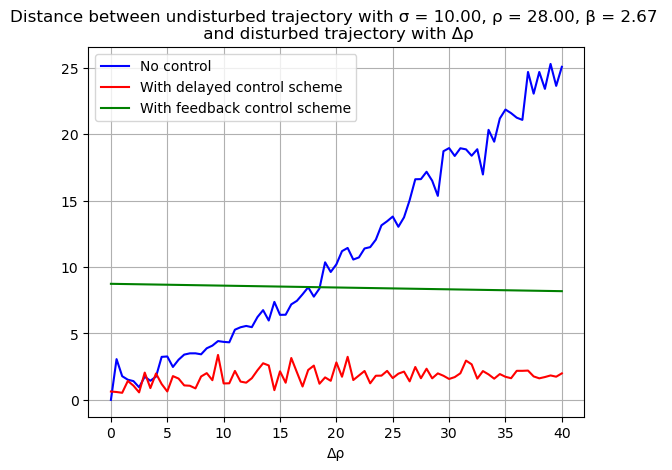

In [27]:
plt.figure()
plt.plot(disturbance_range, rowsnocontrol, 'b-', label = 'No control')
plt.plot(disturbance_range, rowscontrol, 'r-', label = 'With delayed control scheme')
plt.plot(disturbance_range, rowsfeed, 'g-', label = 'With feedback control scheme')

plt.xlabel('\u0394\u03C1')
plt.legend()
plt.title(f"Distance between undisturbed trajectory with \u03C3 = {sigma:.2f}, \u03C1 = {rho:.2f}, \u03B2 = {beta:.2f} \n and disturbed trajectory with \u0394\u03C1")
plt.grid()
plt.show()

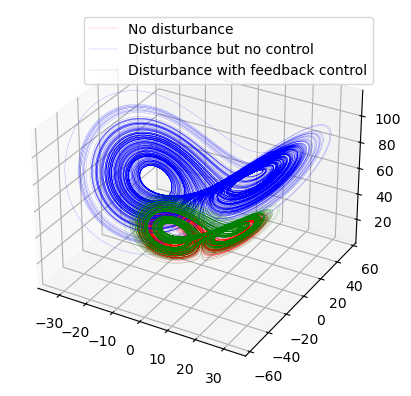

In [32]:
plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.1, label = 'Disturbance with feedback control')
plt.legend()
plt.show()


In [37]:
np.linspace(20, 20, 1)

array([20.])

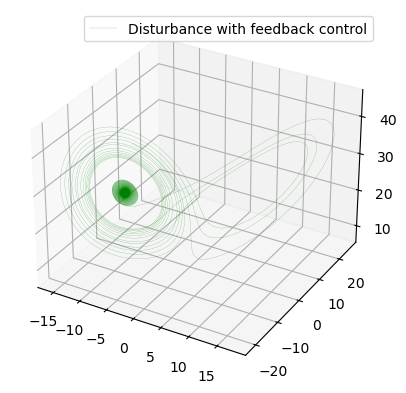

In [35]:

plt.figure()
ax = plt.axes(projection = '3d')
#ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
ax.plot3D(xfeed, yfeed, zfeed, 'g', linewidth = 0.1, label = 'Disturbance with feedback control')
plt.legend()
plt.show()


Progress : 4.12 %

Progress : 8.23 %

Progress : 12.35 %

Progress : 16.46 %

Progress : 20.58 %

Progress : 24.69 %

Progress : 28.81 %

Progress : 32.92 %

Progress : 37.04 %

Progress : 41.15 %

Progress : 45.27 %

Progress : 49.38 %

Progress : 53.50 %

Progress : 57.61 %

Progress : 61.73 %

Progress : 65.84 %

Progress : 69.96 %

Progress : 74.07 %

Progress : 78.19 %

Progress : 82.30 %

Progress : 86.42 %

Progress : 90.53 %

Progress : 94.65 %

Progress : 98.77 %


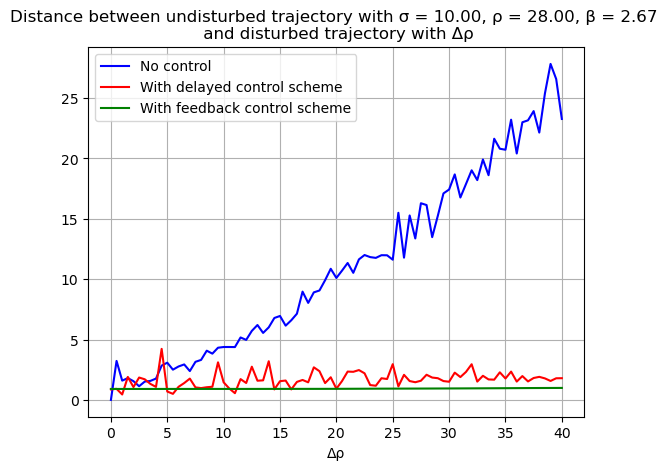

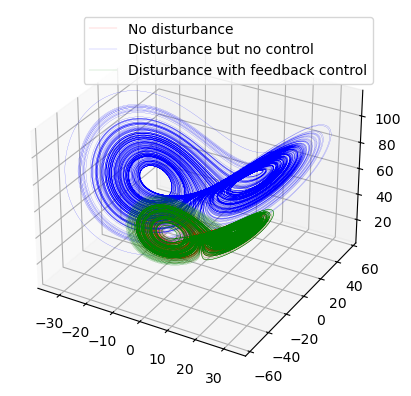

No control : [ 0.          3.23237948  1.59844506  1.80844024  1.55294979  1.13446927
  1.51793776  1.5754003   1.7684014   2.84190446  3.08413338  2.50671548
  2.7710642   2.94007915  2.38916152  3.15680615  3.31523706  4.07854445
  3.83443539  4.32424864  4.38322051  4.38387386  4.37854555  5.17364211
  4.97300221  5.71804372  6.205765    5.55027867  6.01087914  6.78843598
  6.95467385  6.15168057  6.59895673  7.14209042  8.97084413  8.03746125
  8.90978185  9.06591811  9.91709806 10.86413768 10.10380027 10.70961953
 11.34359825 10.5281236  11.64214749 12.00357558 11.83063888 11.7665346
 11.98894537 11.98108167 11.61649452 15.50149579 11.78508164 15.28138525
 13.37477599 16.29349536 16.14428094 13.4837774  15.25485318 17.10687275
 17.43016765 18.68180527 16.76829469 17.89195972 19.0209149  18.20934409
 19.91710481 18.61544236 21.63694617 20.80908355 20.72566324 23.21485948
 20.41217453 23.00128009 23.16180736 23.92580886 22.14585199 25.3845605
 27.83431349 26.58262582 23.2764272 ]
De

In [49]:
## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                    # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Control parameters
alpha = 1000
tau = 10



## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)
controlgain = 0.75

## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Inital state of Lorenz system, reservoir states and forcing function
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))


### Training using the pre-defined forcing functions ###

## Collecting reservoir time-series data for delayed control
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r

    fx = 10 * np.cos(0.05 * dt * t)
    fy = 10 * np.sin(0.05 * dt * t)
    
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)


## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  ## For delayed control


### Training for feedback control

## Inital state of Lorenz system, reservoir states and forcing function
rfeed = 0.5 - 1.0 * np.random.rand(n)
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rfeed
    

    xp = sigma * (y - x)
    yp = x * (rho - z) - y 
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rfeed = np.tanh(A.dot(rfeed) + Win.dot(u) + 1)
    f[:, t] = np.array([x, y, z])

## Finding Wout matrix using ridge regression
Wout_feed = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  ## For feedback control


### Testing delayed control with altered rho ###

Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## The portion from here-on down should be repeated for different values of parameters

## Disturbance range is 0 - 20
## For each disturbance value, repeat the run 3 times and take average of 3


disturbance_range = np.linspace(0, 40, 81)   # change in rho
numberofeach = 3
trials = numberofeach * disturbance_range.shape[0]
avgdistcontrol = np.zeros(trials)
avgdistnocont = np.zeros(trials)
avgdistfeed = np.zeros(trials)
trial_counter = 0
r_init = r
point_indices = np.random.randint(0, 5000 - 1, size = 100)

for disturbance in disturbance_range:
    for attempt in np.arange(numberofeach):

        r = r_init
        rfeed = r_init 
        ux = np.zeros(ntest + 1)
        vx = np.zeros(ntest + 1)

        uy = np.zeros(ntest + 1)
        vy = np.zeros(ntest + 1)


        uz = np.zeros(ntest + 1)
        vz = np.zeros(ntest + 1)

        ## Storing x, y, z time series data when there is disturbance and delayed control is applied
        xcontrol = np.zeros(ntest)             
        ycontrol = np.zeros(ntest)
        zcontrol = np.zeros(ntest)

        ## Storing x, y, z time series data when there is disturbance and feedback control is applied
        xfeed = np.zeros(ntest)             
        yfeed = np.zeros(ntest)
        zfeed = np.zeros(ntest)

        ## Storing x, y, z time series data when there is disturbance and control is not applied
        xnocontrol = np.zeros(ntest)
        ynocontrol = np.zeros(ntest)
        znocontrol = np.zeros(ntest)

        ## Storing x, y, z time series data if there was no disturbance
        xpure = np.zeros(ntest)
        ypure = np.zeros(ntest)
        zpure = np.zeros(ntest)


        xxcontrol, yycontrol, zzcontrol = x, y, z
        xxnocontrol, yynocontrol, zznocontrol = x, y, z
        xxpure, yypure, zzpure = x, y, z
        xxfeed, yyfeed, zzfeed = x, y, z



        for t in range(ntest):

            ## No disturbance and system is evolving with old parameters

            xxpurep = sigma * (yypure - xxpure)
            yypurep = xxpure * (rho - zzpure) - yypure
            zzpurep = xxpure * yypure - beta * zzpure

            xxpure += dt * xxpurep
            yypure += dt * yypurep
            zzpure += dt * zzpurep

            xpure[t] = xxpure
            ypure[t] = yypure
            zpure[t] = zzpure    
            
            

            ## Disturbance but no control
            
            gynocontrol = disturbance * xxnocontrol


            xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
            yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + gynocontrol
            zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
            
            xxnocontrol += dt * xxnocontrolp
            yynocontrol += dt * yynocontrolp
            zznocontrol += dt * zznocontrolp

            xnocontrol[t] = xxnocontrol
            ynocontrol[t] = yynocontrol
            znocontrol[t] = zznocontrol



            ## Disturbance with delayed control

            gycontrol = disturbance * xxcontrol
            

            ux[t], uy[t], uz[t] = Wout.dot(r)

            vx[t + 1] = vx[t] + (dt / tau) * (ux[t] - vx[t])
            vy[t + 1] = vy[t] + (dt / tau) * (uy[t] - vy[t])
            vz[t + 1] = vz[t] + (dt / tau) * (uz[t] - vz[t])

            xxcontrolp = sigma * (yycontrol - xxcontrol) - alpha * vx[t]
            yycontrolp = xxcontrol * (rho - zzcontrol) - yycontrol + gycontrol - alpha * vy[t]
            zzcontrolp = xxcontrol * yycontrol - beta * zzcontrol - alpha * vz[t]

            xxcontrol += dt * xxcontrolp
            yycontrol += dt * yycontrolp
            zzcontrol += dt * zzcontrolp

            xcontrol[t] = xxcontrol
            ycontrol[t] = yycontrol
            zcontrol[t] = zzcontrol

            r = np.tanh(A.dot(r) + Win.dot(np.array([xxcontrol, yycontrol, zzcontrol])) + 1)

            ## Disturbance with feedback control

            gyfeed = disturbance * xxfeed

            xtrack, ytrack, ztrack = Wout_feed.dot(rfeed)
            rfeed = np.tanh(A.dot(rfeed) + Win.dot(np.array([xtrack, ytrack, ztrack])) + 1)


            xxfeedp = sigma * (yyfeed - xxfeed) 
            yyfeedp = xxfeed * (rho - zzfeed) - yyfeed + gyfeed
            zzfeedp = xxfeed * yyfeed - beta * zzfeed
            
            xxfeed += dt * xxfeedp + controlgain * (xtrack - xxfeed)
            yyfeed += dt * yyfeedp + controlgain * (ytrack - yyfeed)
            zzfeed += dt * zzfeedp + controlgain * (ztrack - zzfeed)

            xfeed[t] = xxfeed
            yfeed[t] = yyfeed
            zfeed[t] = zzfeed





        pwithout = np.vstack((xpure[-5000:], ypure[-5000:], zpure[-5000:]))
        pwith = np.vstack((xcontrol[-5000:], ycontrol[-5000:], zcontrol[-5000:]))
        pdistnocont = np.vstack((xnocontrol[-5000:], ynocontrol[-5000:], znocontrol[-5000:]))
        pdistfeed = np.vstack([xfeed[-5000:], yfeed[-5000:], zfeed[-5000:]])
        
        sumdist = 0

        for i in point_indices:
            mindist = norm(pwith[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pwith[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pwith[:, i] - pwithout[:, j])
            sumdist += mindist
        
        avgdistcontrol[trial_counter] = (sumdist/100)

        sumdist = 0

        for i in point_indices:
            mindist = norm(pdistnocont[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pdistnocont[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pdistnocont[:, i] - pwithout[:, j])
            sumdist += mindist
        
        avgdistnocont[trial_counter] = (sumdist/100)

        sumdist = 0

        for i in point_indices:
            mindist = norm(pdistfeed[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pdistfeed[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pdistfeed[:, i] - pwithout[:, j])
            sumdist += mindist
        
        avgdistfeed[trial_counter] = (sumdist/100)



        trial_counter += 1
        if trial_counter % 10 == 0:
            print(f"\nProgress : {trial_counter * 100.0 / trials :.2f} %")


rowscontrol = np.zeros(avgdistcontrol.shape[0] // numberofeach)
for i in np.arange(avgdistcontrol.shape[0]):
    rowscontrol[i // numberofeach] += avgdistcontrol[i]

rowscontrol = rowscontrol / numberofeach

rowsnocontrol = np.zeros(avgdistnocont.shape[0] // numberofeach)
for i in np.arange(avgdistnocont.shape[0]):
    rowsnocontrol[i // numberofeach] += avgdistnocont[i]

rowsnocontrol = rowsnocontrol / numberofeach

rowsfeed = np.zeros(avgdistfeed.shape[0] // numberofeach)
for i in np.arange(avgdistfeed.shape[0]):
    rowsfeed[i // numberofeach] += avgdistfeed[i]

rowsfeed = rowsfeed / numberofeach

plt.figure()
plt.plot(disturbance_range, rowsnocontrol, 'b-', label = 'No control')
plt.plot(disturbance_range, rowscontrol, 'r-', label = 'With delayed control scheme')
plt.plot(disturbance_range, rowsfeed, 'g-', label = 'With feedback control scheme')

plt.xlabel('\u0394\u03C1')
plt.legend()
plt.title(f"Distance between undisturbed trajectory with \u03C3 = {sigma:.2f}, \u03C1 = {rho:.2f}, \u03B2 = {beta:.2f} \n and disturbed trajectory with \u0394\u03C1")
plt.grid()
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
ax.plot3D(xfeed, yfeed, zfeed, 'g', linewidth = 0.1, label = 'Disturbance with feedback control')
plt.legend()
plt.show()

print(f"No control : {rowsnocontrol}\nDelayed control :  {rowscontrol} \nFeedback control : {rowsfeed}")


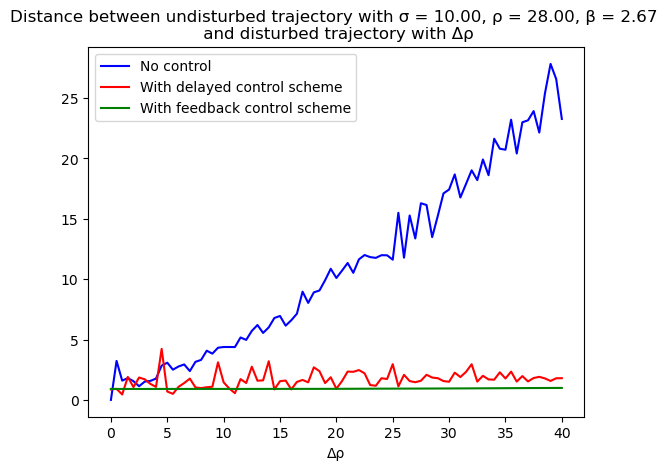

In [51]:
plt.figure()
plt.plot(disturbance_range, rowsnocontrol, 'b-', label = 'No control')
plt.plot(disturbance_range, rowscontrol, 'r-', label = 'With delayed control scheme')
plt.plot(disturbance_range, rowsfeed, 'g-', label = 'With feedback control scheme')
plt.xlabel('\u0394\u03C1')
plt.legend()
plt.title(f"Distance between undisturbed trajectory with \u03C3 = {sigma:.2f}, \u03C1 = {rho:.2f}, \u03B2 = {beta:.2f} \n and disturbed trajectory with \u0394\u03C1")
plt.show()


Progress : 47.62 %

Delayed control distance: 1.9800751689210818

Feedback control distance : 8.215282381091827

Progress : 95.24 %

Delayed control distance: 4.053705855216594

Feedback control distance : 8.265036608468028


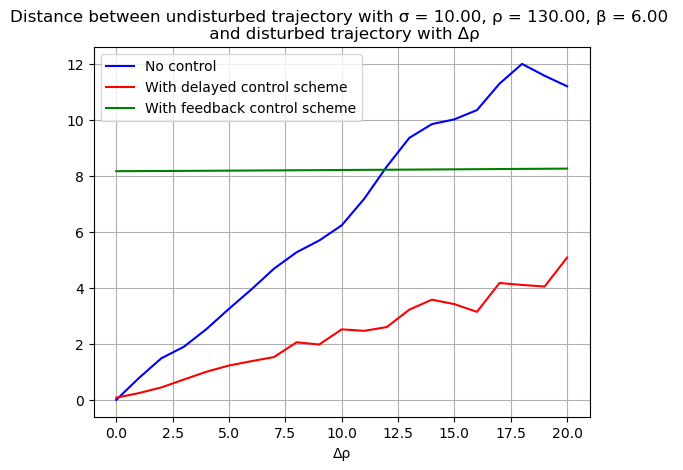

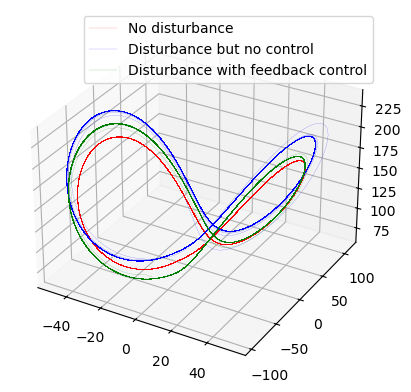

No control : [ 0.          0.77820459  1.48846464  1.90058367  2.53175331  3.25702146
  3.95398043  4.69498047  5.27894736  5.69805056  6.24117358  7.19182155
  8.34380708  9.36929739  9.86143111 10.03099239 10.36213076 11.30747664
 12.01304907 11.5898116  11.21346727]
Delayed control :  [0.07817579 0.24339967 0.44695508 0.72941662 1.00745047 1.23019425
 1.38553945 1.53254735 2.06098606 1.98007517 2.52305479 2.46992507
 2.60510704 3.2272532  3.58442676 3.42413712 3.14906367 4.18012368
 4.1119885  4.05370586 5.09124529] 
Feedback control : [8.17765219 8.18124676 8.18512392 8.18906493 8.19303475 8.19724167
 8.20160781 8.20605892 8.21062023 8.21528238 8.22001774 8.22474835
 8.2294927  8.23437321 8.23942077 8.24457703 8.24969405 8.25475171
 8.2598298  8.26503661 8.27036859]


In [ ]:
## Lorenz system parameters 
sigma = 10
rho = 130
beta = 6

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                    # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Control parameters
alpha = 1000
tau = 10



## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)
controlgain = 1

## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Inital state of Lorenz system, reservoir states and forcing function
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))


### Training using the pre-defined forcing functions ###

## Collecting reservoir time-series data for delayed control
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r

    fx = 10 * np.cos(0.05 * dt * t)
    fy = 10 * np.sin(0.05 * dt * t)
    
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)


## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  ## For delayed control


### Training for feedback control

## Inital state of Lorenz system, reservoir states and forcing function
rfeed = 0.5 - 1.0 * np.random.rand(n)
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rfeed
    

    xp = sigma * (y - x)
    yp = x * (rho - z) - y 
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rfeed = np.tanh(A.dot(rfeed) + Win.dot(u) + 1)
    f[:, t] = np.array([x, y, z])

## Finding Wout matrix using ridge regression
Wout_feed = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  ## For feedback control


### Testing delayed control with altered rho ###

Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## The portion from here-on down should be repeated for different values of parameters

## Disturbance range is 0 - 20
## For each disturbance value, repeat the run 3 times and take average of 3


disturbance_range = np.linspace(0, 20, 21)   # change in rho
numberofeach = 1
trials = numberofeach * disturbance_range.shape[0]
avgdistcontrol = np.zeros(trials)
avgdistnocont = np.zeros(trials)
avgdistfeed = np.zeros(trials)
trial_counter = 0
r_init = r
point_indices = np.random.randint(0, 5000 - 1, size = 100)

for disturbance in disturbance_range:
    for attempt in np.arange(numberofeach):

        r = r_init
        rfeed = r_init 
        ux = np.zeros(ntest + 1)
        vx = np.zeros(ntest + 1)

        uy = np.zeros(ntest + 1)
        vy = np.zeros(ntest + 1)


        uz = np.zeros(ntest + 1)
        vz = np.zeros(ntest + 1)

        ## Storing x, y, z time series data when there is disturbance and delayed control is applied
        xcontrol = np.zeros(ntest)             
        ycontrol = np.zeros(ntest)
        zcontrol = np.zeros(ntest)

        ## Storing x, y, z time series data when there is disturbance and feedback control is applied
        xfeed = np.zeros(ntest)             
        yfeed = np.zeros(ntest)
        zfeed = np.zeros(ntest)

        ## Storing x, y, z time series data when there is disturbance and control is not applied
        xnocontrol = np.zeros(ntest)
        ynocontrol = np.zeros(ntest)
        znocontrol = np.zeros(ntest)

        ## Storing x, y, z time series data if there was no disturbance
        xpure = np.zeros(ntest)
        ypure = np.zeros(ntest)
        zpure = np.zeros(ntest)


        xxcontrol, yycontrol, zzcontrol = x, y, z
        xxnocontrol, yynocontrol, zznocontrol = x, y, z
        xxpure, yypure, zzpure = x, y, z
        xxfeed, yyfeed, zzfeed = x, y, z



        for t in range(ntest):

            ## No disturbance and system is evolving with old parameters

            xxpurep = sigma * (yypure - xxpure)
            yypurep = xxpure * (rho - zzpure) - yypure
            zzpurep = xxpure * yypure - beta * zzpure

            xxpure += dt * xxpurep
            yypure += dt * yypurep
            zzpure += dt * zzpurep

            xpure[t] = xxpure
            ypure[t] = yypure
            zpure[t] = zzpure    
            
            

            ## Disturbance but no control
            
            gynocontrol = disturbance * xxnocontrol


            xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
            yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + gynocontrol
            zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
            
            xxnocontrol += dt * xxnocontrolp
            yynocontrol += dt * yynocontrolp
            zznocontrol += dt * zznocontrolp

            xnocontrol[t] = xxnocontrol
            ynocontrol[t] = yynocontrol
            znocontrol[t] = zznocontrol



            ## Disturbance with delayed control

            gycontrol = disturbance * xxcontrol
            

            ux[t], uy[t], uz[t] = Wout.dot(r)

            vx[t + 1] = vx[t] + (dt / tau) * (ux[t] - vx[t])
            vy[t + 1] = vy[t] + (dt / tau) * (uy[t] - vy[t])
            vz[t + 1] = vz[t] + (dt / tau) * (uz[t] - vz[t])

            xxcontrolp = sigma * (yycontrol - xxcontrol) - alpha * vx[t]
            yycontrolp = xxcontrol * (rho - zzcontrol) - yycontrol + gycontrol - alpha * vy[t]
            zzcontrolp = xxcontrol * yycontrol - beta * zzcontrol - alpha * vz[t]

            xxcontrol += dt * xxcontrolp
            yycontrol += dt * yycontrolp
            zzcontrol += dt * zzcontrolp

            xcontrol[t] = xxcontrol
            ycontrol[t] = yycontrol
            zcontrol[t] = zzcontrol

            r = np.tanh(A.dot(r) + Win.dot(np.array([xxcontrol, yycontrol, zzcontrol])) + 1)

            ## Disturbance with feedback control

            gyfeed = disturbance * xxfeed

            xtrack, ytrack, ztrack = Wout_feed.dot(rfeed)
            rfeed = np.tanh(A.dot(rfeed) + Win.dot(np.array([xtrack, ytrack, ztrack])) + 1)


            xxfeedp = sigma * (yyfeed - xxfeed) 
            yyfeedp = xxfeed * (rho - zzfeed) - yyfeed + gyfeed
            zzfeedp = xxfeed * yyfeed - beta * zzfeed
            
            xxfeed += dt * xxfeedp + controlgain * (xtrack - xxfeed)
            yyfeed += dt * yyfeedp + controlgain * (ytrack - yyfeed)
            zzfeed += dt * zzfeedp + controlgain * (ztrack - zzfeed)

            xfeed[t] = xxfeed
            yfeed[t] = yyfeed
            zfeed[t] = zzfeed





        pwithout = np.vstack((xpure[-5000:], ypure[-5000:], zpure[-5000:]))
        pwith = np.vstack((xcontrol[-5000:], ycontrol[-5000:], zcontrol[-5000:]))
        pdistnocont = np.vstack((xnocontrol[-5000:], ynocontrol[-5000:], znocontrol[-5000:]))
        pdistfeed = np.vstack([xfeed[-5000:], yfeed[-5000:], zfeed[-5000:]])
        
        sumdist = 0

        for i in point_indices:
            mindist = norm(pwith[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pwith[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pwith[:, i] - pwithout[:, j])
            sumdist += mindist
        
        avgdistcontrol[trial_counter] = (sumdist/100)

        sumdist = 0

        for i in point_indices:
            mindist = norm(pdistnocont[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pdistnocont[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pdistnocont[:, i] - pwithout[:, j])
            sumdist += mindist
        
        avgdistnocont[trial_counter] = (sumdist/100)

        sumdist = 0

        for i in point_indices:
            mindist = norm(pdistfeed[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pdistfeed[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pdistfeed[:, i] - pwithout[:, j])
            sumdist += mindist
        
        avgdistfeed[trial_counter] = (sumdist/100)



        trial_counter += 1
        if trial_counter % 10 == 0:
            print(f"\nProgress : {trial_counter * 100.0 / trials :.2f} %")
            print(f"\nDelayed control distance: {avgdistcontrol[trial_counter - 1]}")
            print(f"\nFeedback control distance : {avgdistfeed[trial_counter - 1]}")


rowscontrol = np.zeros(avgdistcontrol.shape[0] // numberofeach)
for i in np.arange(avgdistcontrol.shape[0]):
    rowscontrol[i // numberofeach] += avgdistcontrol[i]

rowscontrol = rowscontrol / numberofeach

rowsnocontrol = np.zeros(avgdistnocont.shape[0] // numberofeach)
for i in np.arange(avgdistnocont.shape[0]):
    rowsnocontrol[i // numberofeach] += avgdistnocont[i]

rowsnocontrol = rowsnocontrol / numberofeach

rowsfeed = np.zeros(avgdistfeed.shape[0] // numberofeach)
for i in np.arange(avgdistfeed.shape[0]):
    rowsfeed[i // numberofeach] += avgdistfeed[i]

rowsfeed = rowsfeed / numberofeach

plt.figure()
plt.plot(disturbance_range, rowsnocontrol, 'b-', label = 'No control')
plt.plot(disturbance_range, rowscontrol, 'r-', label = 'With delayed control scheme')
plt.plot(disturbance_range, rowsfeed, 'g-', label = 'With feedback control scheme')

plt.xlabel('\u0394\u03C1')
plt.legend()
plt.title(f"Distance between undisturbed trajectory with \u03C3 = {sigma:.2f}, \u03C1 = {rho:.2f}, \u03B2 = {beta:.2f} \n and disturbed trajectory with \u0394\u03C1")
plt.grid()
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
ax.plot3D(xfeed, yfeed, zfeed, 'g', linewidth = 0.1, label = 'Disturbance with feedback control')
plt.legend()
plt.show()

print(f"No control : {rowsnocontrol}\nDelayed control :  {rowscontrol} \nFeedback control : {rowsfeed}")


In [63]:
avgdistcontrol

array([0.01636125, 0.01636125, 0.01636125, 0.14567949, 0.14567949,
       0.14567949, 0.2377367 , 0.2377367 , 0.2377367 , 0.39586063,
       0.39586063, 0.39586063, 0.44744887, 0.44744887, 0.44744887,
       0.65227688, 0.65227688, 0.65227688, 0.71051629, 0.71051629,
       0.71051629, 0.81090487, 0.81090487, 0.81090487, 1.00632679,
       1.00632679, 1.00632679, 1.08147968, 1.08147968, 1.08147968,
       1.10342836, 1.10342836, 1.10342836, 1.32960717, 1.32960717,
       1.32960717, 1.52085558, 1.52085558, 1.52085558, 1.38345405,
       1.38345405, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [42]:
rowsfeed

array([3.32656865])

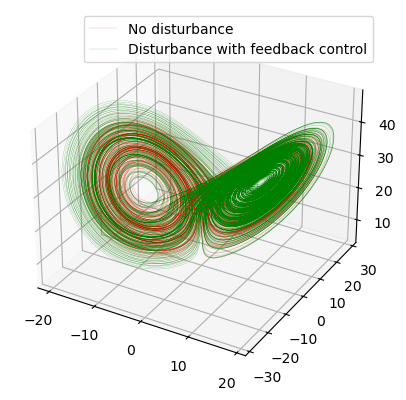

In [50]:
plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
ax.plot3D(xfeed, yfeed, zfeed, 'g', linewidth = 0.1, label = 'Disturbance with feedback control')
plt.legend()
plt.show()

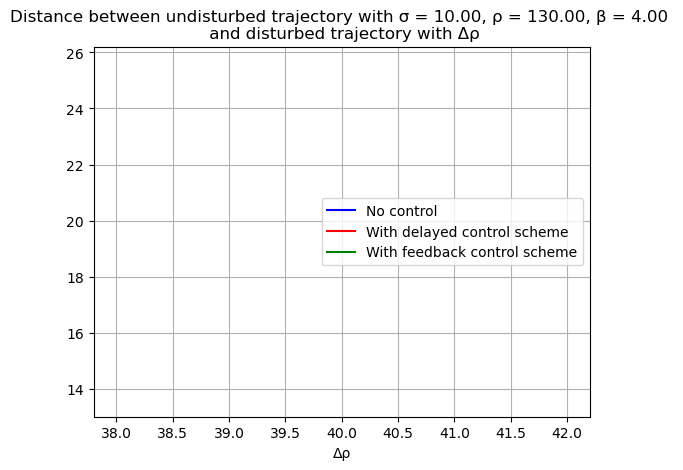

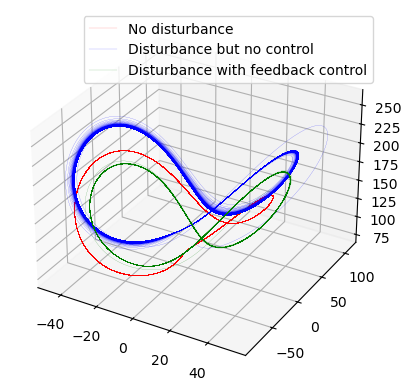

No control : [25.58994554]
Delayed control :  [13.59899873] 
Feedback control : [24.38488352]


In [60]:
## Lorenz system parameters 
sigma = 10
rho = 130
beta = 4

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                    # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Control parameters
alpha = 1000
tau = 10



## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)
controlgain = 1

## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Inital state of Lorenz system, reservoir states and forcing function
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))


### Training using the pre-defined forcing functions ###

## Collecting reservoir time-series data for delayed control
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r

    fx = 10 * np.cos(0.05 * dt * t)
    fy = 10 * np.sin(0.05 * dt * t)
    
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)


## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  ## For delayed control


### Training for feedback control

## Inital state of Lorenz system, reservoir states and forcing function
rfeed = 0.5 - 1.0 * np.random.rand(n)
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rfeed
    

    xp = sigma * (y - x)
    yp = x * (rho - z) - y 
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rfeed = np.tanh(A.dot(rfeed) + Win.dot(u) + 1)
    f[:, t] = np.array([x, y, z])

## Finding Wout matrix using ridge regression
Wout_feed = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  ## For feedback control


### Testing delayed control with altered rho ###

Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## The portion from here-on down should be repeated for different values of parameters

## Disturbance range is 0 - 20
## For each disturbance value, repeat the run 3 times and take average of 3


disturbance_range = np.linspace(40, 40, 1)   # change in rho
numberofeach = 3
trials = numberofeach * disturbance_range.shape[0]
avgdistcontrol = np.zeros(trials)
avgdistnocont = np.zeros(trials)
avgdistfeed = np.zeros(trials)
trial_counter = 0
r_init = r
point_indices = np.random.randint(0, 5000 - 1, size = 100)

for disturbance in disturbance_range:
    for attempt in np.arange(numberofeach):

        r = r_init
        rfeed = r_init 
        ux = np.zeros(ntest + 1)
        vx = np.zeros(ntest + 1)

        uy = np.zeros(ntest + 1)
        vy = np.zeros(ntest + 1)


        uz = np.zeros(ntest + 1)
        vz = np.zeros(ntest + 1)

        ## Storing x, y, z time series data when there is disturbance and delayed control is applied
        xcontrol = np.zeros(ntest)             
        ycontrol = np.zeros(ntest)
        zcontrol = np.zeros(ntest)

        ## Storing x, y, z time series data when there is disturbance and feedback control is applied
        xfeed = np.zeros(ntest)             
        yfeed = np.zeros(ntest)
        zfeed = np.zeros(ntest)

        ## Storing x, y, z time series data when there is disturbance and control is not applied
        xnocontrol = np.zeros(ntest)
        ynocontrol = np.zeros(ntest)
        znocontrol = np.zeros(ntest)

        ## Storing x, y, z time series data if there was no disturbance
        xpure = np.zeros(ntest)
        ypure = np.zeros(ntest)
        zpure = np.zeros(ntest)


        xxcontrol, yycontrol, zzcontrol = x, y, z
        xxnocontrol, yynocontrol, zznocontrol = x, y, z
        xxpure, yypure, zzpure = x, y, z
        xxfeed, yyfeed, zzfeed = x, y, z



        for t in range(ntest):

            ## No disturbance and system is evolving with old parameters

            xxpurep = sigma * (yypure - xxpure)
            yypurep = xxpure * (rho - zzpure) - yypure
            zzpurep = xxpure * yypure - beta * zzpure

            xxpure += dt * xxpurep
            yypure += dt * yypurep
            zzpure += dt * zzpurep

            xpure[t] = xxpure
            ypure[t] = yypure
            zpure[t] = zzpure    
            
            

            ## Disturbance but no control
            
            gynocontrol = disturbance * xxnocontrol


            xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
            yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + gynocontrol
            zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
            
            xxnocontrol += dt * xxnocontrolp
            yynocontrol += dt * yynocontrolp
            zznocontrol += dt * zznocontrolp

            xnocontrol[t] = xxnocontrol
            ynocontrol[t] = yynocontrol
            znocontrol[t] = zznocontrol



            ## Disturbance with delayed control

            gycontrol = disturbance * xxcontrol
            

            ux[t], uy[t], uz[t] = Wout.dot(r)

            vx[t + 1] = vx[t] + (dt / tau) * (ux[t] - vx[t])
            vy[t + 1] = vy[t] + (dt / tau) * (uy[t] - vy[t])
            vz[t + 1] = vz[t] + (dt / tau) * (uz[t] - vz[t])

            xxcontrolp = sigma * (yycontrol - xxcontrol) - alpha * vx[t]
            yycontrolp = xxcontrol * (rho - zzcontrol) - yycontrol + gycontrol - alpha * vy[t]
            zzcontrolp = xxcontrol * yycontrol - beta * zzcontrol - alpha * vz[t]

            xxcontrol += dt * xxcontrolp
            yycontrol += dt * yycontrolp
            zzcontrol += dt * zzcontrolp

            xcontrol[t] = xxcontrol
            ycontrol[t] = yycontrol
            zcontrol[t] = zzcontrol

            r = np.tanh(A.dot(r) + Win.dot(np.array([xxcontrol, yycontrol, zzcontrol])) + 1)

            ## Disturbance with feedback control

            gyfeed = disturbance * xxfeed

            xtrack, ytrack, ztrack = Wout_feed.dot(rfeed)
            rfeed = np.tanh(A.dot(rfeed) + Win.dot(np.array([xtrack, ytrack, ztrack])) + 1)


            xxfeedp = sigma * (yyfeed - xxfeed) 
            yyfeedp = xxfeed * (rho - zzfeed) - yyfeed + gyfeed
            zzfeedp = xxfeed * yyfeed - beta * zzfeed
            
            xxfeed += dt * xxfeedp + controlgain * (xtrack - xxfeed)
            yyfeed += dt * yyfeedp + controlgain * (ytrack - yyfeed)
            zzfeed += dt * zzfeedp + controlgain * (ztrack - zzfeed)

            xfeed[t] = xxfeed
            yfeed[t] = yyfeed
            zfeed[t] = zzfeed





        pwithout = np.vstack((xpure[-5000:], ypure[-5000:], zpure[-5000:]))
        pwith = np.vstack((xcontrol[-5000:], ycontrol[-5000:], zcontrol[-5000:]))
        pdistnocont = np.vstack((xnocontrol[-5000:], ynocontrol[-5000:], znocontrol[-5000:]))
        pdistfeed = np.vstack([xfeed[-5000:], yfeed[-5000:], zfeed[-5000:]])
        
        sumdist = 0

        for i in point_indices:
            mindist = norm(pwith[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pwith[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pwith[:, i] - pwithout[:, j])
            sumdist += mindist
        
        avgdistcontrol[trial_counter] = (sumdist/100)

        sumdist = 0

        for i in point_indices:
            mindist = norm(pdistnocont[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pdistnocont[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pdistnocont[:, i] - pwithout[:, j])
            sumdist += mindist
        
        avgdistnocont[trial_counter] = (sumdist/100)

        sumdist = 0

        for i in point_indices:
            mindist = norm(pdistfeed[:, i] - pwithout[:, 0])
            for j in range(pwithout.shape[1]):
                if norm(pdistfeed[:, i] - pwithout[:, j]) < mindist :
                    mindist = norm(pdistfeed[:, i] - pwithout[:, j])
            sumdist += mindist
        
        avgdistfeed[trial_counter] = (sumdist/100)



        trial_counter += 1
        if trial_counter % 10 == 0:
            print(f"\nProgress : {trial_counter * 100.0 / trials :.2f} %")


rowscontrol = np.zeros(avgdistcontrol.shape[0] // numberofeach)
for i in np.arange(avgdistcontrol.shape[0]):
    rowscontrol[i // numberofeach] += avgdistcontrol[i]

rowscontrol = rowscontrol / numberofeach

rowsnocontrol = np.zeros(avgdistnocont.shape[0] // numberofeach)
for i in np.arange(avgdistnocont.shape[0]):
    rowsnocontrol[i // numberofeach] += avgdistnocont[i]

rowsnocontrol = rowsnocontrol / numberofeach

rowsfeed = np.zeros(avgdistfeed.shape[0] // numberofeach)
for i in np.arange(avgdistfeed.shape[0]):
    rowsfeed[i // numberofeach] += avgdistfeed[i]

rowsfeed = rowsfeed / numberofeach

plt.figure()
plt.plot(disturbance_range, rowsnocontrol, 'b-', label = 'No control')
plt.plot(disturbance_range, rowscontrol, 'r-', label = 'With delayed control scheme')
plt.plot(disturbance_range, rowsfeed, 'g-', label = 'With feedback control scheme')

plt.xlabel('\u0394\u03C1')
plt.legend()
plt.title(f"Distance between undisturbed trajectory with \u03C3 = {sigma:.2f}, \u03C1 = {rho:.2f}, \u03B2 = {beta:.2f} \n and disturbed trajectory with \u0394\u03C1")
plt.grid()
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
ax.plot3D(xfeed, yfeed, zfeed, 'g', linewidth = 0.1, label = 'Disturbance with feedback control')
plt.legend()
plt.show()

print(f"No control : {rowsnocontrol}\nDelayed control :  {rowscontrol} \nFeedback control : {rowsfeed}")
